In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn import preprocessing
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
def read_csv(filename):
    """
    Function reading the value of a csv file and return it in a Pandas DataFrame
    :param filename: String which contain the location of the csv file
    :return: Pandas DataFrame which contain the values
    """
    return pd.read_csv(filename)

In [3]:
class MLR_Gradient():
    """
    Class of the Multiple Linear Regression using gradient descent
    """

    def __init__(self, scenario, df, ratio, x_columns, y_columns, alpha, iterations,plot=True ):
        """
        Constructor of the Class
        :param scenario: String of the scenario
        :param df: Pandas DataFrame with the values
        :param ratio: Value of the ratio between train and test values
        :param x_columns: List of String containing the name of the x columns in the DataFrame
        :param y_columns: String containing the name of the y column in the DataFrame
        :param alpha: Value of the learning rate of our model
        :param iterations: Number of iterations
        :param plot:
        """
        #Initialize all the variables of the instance
        self.scenario = scenario
        self.hist_thetas = []
        self.hist_cost = []
        self.X_train = 0
        self.y_train = 0
        self.X_test = 0
        self.y_test = 0
        self.y_pred = 0
        self.r2 = 0
        self.sk_coefs = 0
        self.sk_r2 = 0
        self.sk_MSE = 0
        self.MSE = 0
        self.MAE = 0
        self.sk_MAE = 0
        self.RMSE = 0
        self.sk_RMSE =0
        self.df = df
        self.ratio = ratio
        self.x_columns = x_columns
        self.y_columns = y_columns
        self.alpha = alpha
        self.iterations = iterations
        self.plot = plot
        self.convergence =0

        self.split_df() #Split between train and test value

        self.X_train=self.normalize_data(self.X_train) #Normalize the trained value of X
        self.X_test=self.normalize_data(self.X_test) #Normalize the tested value of X
        self.y_train=self.normalize_data(self.y_train) #Normalize the trained value of y (optional)
        self.y_test=self.normalize_data(self.y_test) #Normalize the tested value of y (optional)

        self.compute_sklearn() #Compute using SkLearn to verify later the accuracy of our predictions and model

        self.gradient_descent() #Using Gradient Descent Algorithm on our model
        self.prediction() #Predict the y using the X value of testing
        self.compute_r2() #Compute the R2 metric of our model
        self.compute_MSE() #Compute the Mean Square Error metric of our model
        self.compute_MAE() #Compute the Mean Absolute Error metric of our model

        if plot : #If the user specified that he wants the graphs, the different graphs, metric and table will be print
            self.plot_prediction()
            self.plot_cost()
            self.plot_thetas()
            self.print_table()

    def split_df(self):
        """
        Function splitting the DataFrame values into test and train series
        """
        #Mixing the value inside the DataFrame and then split the DataFrame using the ratio choose by the user
        mix_df = self.df.sample(frac=1)
        i = int(len(self.df) * self.ratio)
        df_train = mix_df[:i]
        df_test = mix_df[i:]
        #Isolate the value into the corresponding series
        self.X_train = df_train[self.x_columns]
        self.y_train = df_train[self.y_columns]
        self.X_test = df_test[self.x_columns]
        self.y_test = df_test[self.y_columns]

    @staticmethod
    def normalize_data(X):
        """
        Function normalizing the data of a series.
        This function use the mean normalization : subtract the average value from the input variable and then divide it  by standard deviation of input variable.
        :param X: Series to normalized
        :return: The update normalized series
        """
        mu = np.mean(X, axis=0)
        sig = np.std(X, axis=0)
        X_norm = (X - mu)/sig
        return X_norm

    # @staticmethod
    def calc_cost(self,error, m):
        """
        Function that calculate the cost function for a specific value of theta
        :param error: 2D matrix of the error, calculate in gradient_descent() with y_predicted - y
        :param m: number of training example
        :return: Cost value
        """
        error_sqr = np.square(error)
        J = 1/(2 * m) * np.dot(error.T,error) #(1/2m)*sum[(error)^2]
        return J

    @staticmethod
    def grad_array(X,error):
        """
        Function that compute the gradient of each theta parameters
        :param X: Series containing the value of X to train
        :param error: 2D matrix of the error, calculate in gradient_descent() with y_predicted - y
        :return: 2D array of the gradient of
        """
        return (1/len(X))*np.dot(X.T,error) # (1/m) * sum[error*x]

    @staticmethod
    def update_thetas(thetas,grad,alpha):
        """
        Used to update theta array after each iteration
        :param thetas: series of the current thetas
        :param grad: gradient of each theta parameter, obtained from grad_array()
        :param alpha: learning rate
        :return: series containing the updated thetas
        """
        return thetas-alpha*grad

    def gradient_descent(self):
        """
        Algorithm using the gradient descent algorithm to find the accurate thetas and minimize the cost function
        """
        self.X_train = np.hstack((np.ones((len(self.X_train),1)), self.X_train)) #Insert column of 1 in the X matrix

        thetas = np.zeros(self.X_train.shape[1]) #Initialize thetas
        self.hist_thetas.append(thetas)
        self.hist_cost.append(1e10)

        for i in range(self.iterations): #Loop for each iteration
            y_pred=np.dot(self.X_train,thetas) #Calculate the predicted y using X_train and current thetas

            # error = np.subtract(y_pred,self.y_train) #Calculate the error: y_pred - y
            error = y_pred - self.y_train
            grad = self.grad_array(self.X_train,error) #Compute the gradient array

            thetas = self.update_thetas(thetas, grad, self.alpha) #Update the value of thetas using the gradient array
            self.hist_thetas.append(thetas)

            cost = self.calc_cost(error,len(self.X_train)) #Compute cost and append it to history
            self.hist_cost.append(cost)

            if max(abs(np.subtract(self.hist_thetas[i],self.hist_thetas[i+1]))) < 1e-6:
                self.convergence=i+1
                break
        self.hist_cost.pop(0)

        if self.convergence==0:
            self.convergence=self.iterations

    def prediction(self):
        """
        Function computing the predicted y using the last value of thetas found using the gradient descent algorithm and the testing value of X
        """
        self.X_test = np.hstack((np.ones((len(self.X_test),1)), self.X_test)) #Insert column of 1 in the X matrix
        self.y_pred = np.dot(self.X_test,self.hist_thetas[-1])

    def compute_r2(self):
        """
        Function computing the R2 metric value of the model
        """
        sst = np.sum((self.y_test-self.y_test.mean())**2)
        ssr = np.sum((self.y_pred-self.y_test)**2)
        self.r2 = 1-(ssr/sst)

    def compute_MSE(self):
        """
        Function computing the Mean Squared Error metric value of the model
        """
        self.MSE = mean_squared_error(self.y_test,self.y_pred)

    def compute_MAE(self):
        """
        Function computing the Mean Absolute Error metric value of the model
        """
        self.MAE = mean_absolute_error(self.y_test,self.y_pred)

    def compute_sklearn(self):
        """
        Function computing the model and its metric using the SkLearn library, it will be used to validate the result of our manual method
        """
        lm = LinearRegression()
        lm = lm.fit(self.X_train,self.y_train) #Train the model with our trained values
        yp = lm.predict(self.X_test) #Predict the outcome using our testing values
        self.sk_r2 = r2_score(self.y_test,yp)
        #Calculate metrics and coefficients
        self.sk_coefs = np.hstack((lm.intercept_,lm.coef_))
        self.sk_MSE =mean_squared_error(self.y_test,yp)
        self.sk_MAE =mean_absolute_error(self.y_test,yp)

    def plot_prediction(self):
        """
        Function plotting the predicted outcome with and the real value
        """
        plt.figure(figsize=(10,4))
        plt.subplot(1, 2, 1)
        plt.suptitle("Scenario: %s" % self.scenario,fontsize=14)
        X_test,pred=map(list, zip(*sorted(zip(self.y_test,self.y_pred)))) #Sort the values in ascending order
        sns.scatterplot(pred,label="y_pred")
        sns.scatterplot(X_test,label="y_test",c="r")
        plt.title("Prediction")
        plt.legend()
        # plt.show()

    def plot_cost(self):
        """
        Function plotting the evolution of the cost function through the iterations
        """
        plt.subplot(1, 4, 3)
        plt.plot(self.hist_cost,label="Cost function")
        plt.title("Cost function")
        plt.xlabel("Number of iteration")
        plt.ylabel("Cost")
        plt.legend()
        # plt.show()

    def plot_thetas(self):
        """
        Function plotting the evolution of thetas through the iterations
        """
        plt.subplot(1, 4, 4)
        legend =[]
        for i,theta in enumerate(self.hist_thetas[-1]):
            legend.append("Theta %i" % i)
        plt.plot(self.hist_thetas, label=legend)
        plt.title("Thetas")
        plt.xlabel("Number of iteration")
        plt.ylabel("Theta")
        plt.legend()
        plt.tight_layout()
        plt.show()


    def print_table(self):
        """
        Function plotting table of all the metrics of our manual and SkLearn model
        """
        df=pd.DataFrame(index=["Manual","SkLearn","Difference [%]"] )
        for i,theta in enumerate(self.hist_thetas[-1]):
            df["θ%i" %i]=[theta,self.sk_coefs[i],abs(theta-self.sk_coefs[i])/self.sk_coefs[i]*100]
        df["R2"]=[self.r2,self.sk_r2,abs(self.r2-self.sk_r2)/self.sk_r2*100]
        df["MAE"]=[self.MAE,self.sk_MAE,abs(self.MAE-self.sk_MAE)/self.sk_MAE*100]
        df["MSE"]=[self.MSE,self.sk_MSE,abs(self.MSE-self.sk_MSE)/self.sk_MSE*100]
        df["RMSE"]=np.sqrt(df["MSE"])
        display(df)

In [4]:
def data_analyse(df):
    """
    Function to analyse a DataFrame, find correlation between value, metrics and have a global understanding of the values we will use for our model
    :param df: Pandas DataFrame
    """
    display(df.head()) #Head of the DataFrame
    display(df.info()) #Infos of the DataFrame
    display(df.describe()) #Metrics of the DataFrame
    sns.heatmap(abs(df.corr())) #Heatmap of the Columns
    sns.pairplot(df) #Pairplot of the Columns
    fig = px.box(df) #Boxplot of the DataFrame
    fig.show()

In [5]:
def plot_graph(legend,title,*args):
    """
    Function plotting the cost function of several model ton asses the effect of different learning rate
    :param legend: Array of the different legend of the graph
    :param args: Array containing the historic of the cost function through the iteration
    """
    for i,arg in enumerate(args):
        plt.plot(arg, label=legend[i])
    plt.legend()
    plt.title(title)
    plt.xlabel("Number of iteration")
    plt.ylabel("Cost Function")
    plt.show()

In [6]:
#Open and read the value of csv files
df1=read_csv("dataLoans.csv")
df2=read_csv("dataEnergy.csv")
df1=df1.astype(np.float64)
df1=df1.dropna()

First Part : DF2 : dataEnergy.csv

AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


None

AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365001
std       7.452473    12.707893     5.938784    14.600269    17.066996
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000

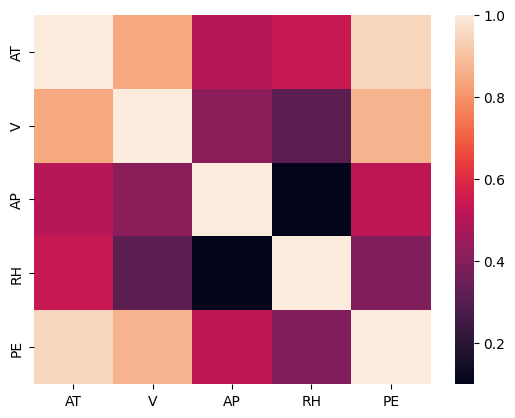

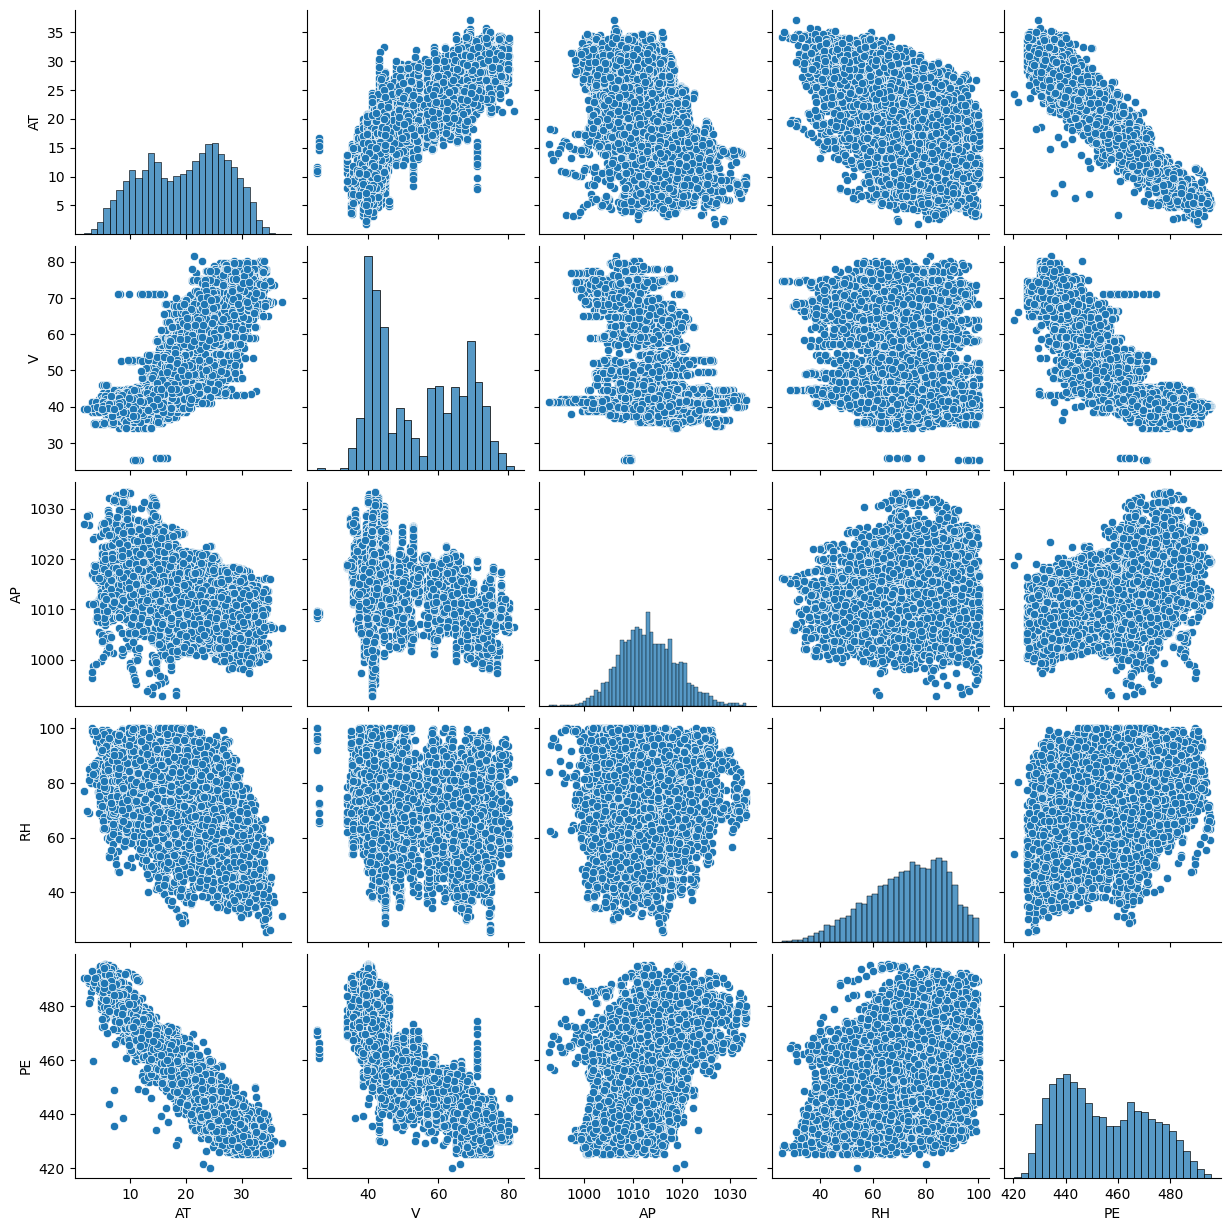

In [7]:
data_analyse(df2)

Scenario 1 : Test of the Multi-Linear Regression with different dependent parameters and analyse their effect on the model

Test1 : prediction from AT

Test2 : prediction from AT,V

Test3 : prediction from AT,V,AP

Test4 : prediction from AT,V,AP,RH

This choice order is made following the analysis of the dataset using the pearson coefficient (Heatmap)
Starting from the more dependent parameter (AT) and adding the following ones, one after the other

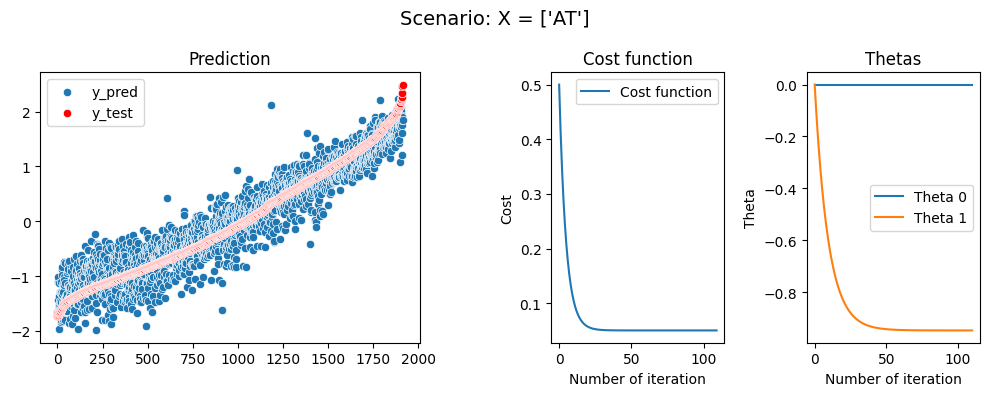

θ0        θ1        R2       MAE       MSE      RMSE
Manual          3.845697e-15 -0.948229  0.898063  0.252032  0.101937  0.319275
SkLearn         3.844906e-15 -0.948238  0.898063  0.252032  0.101937  0.319275
Difference [%]  2.057146e-02 -0.000926  0.000001  0.000117  0.000010  0.003137

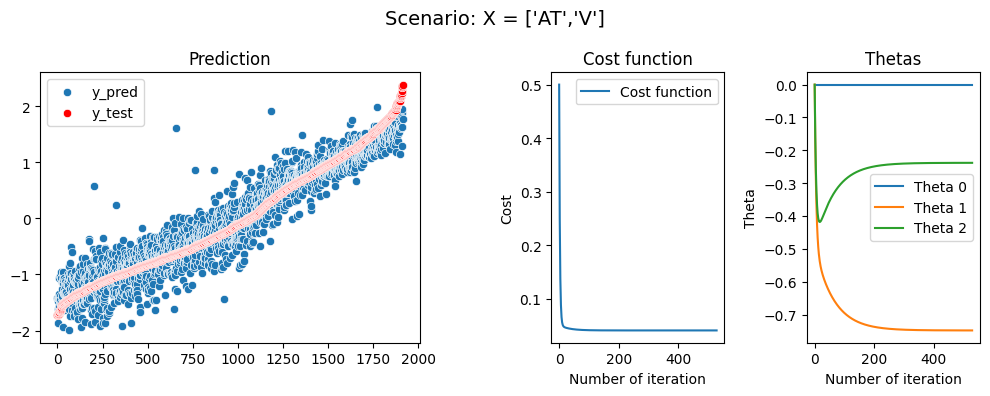

θ0        θ1        θ2        R2       MAE  \
Manual         -2.978615e-16 -0.748494 -0.238146  0.906538  0.238846   
SkLearn        -2.984574e-16 -0.748557 -0.238084  0.906537  0.238846   
Difference [%] -1.996475e-01 -0.008378 -0.026340  0.000085  0.000361   

                     MSE      RMSE  
Manual          0.093462  0.305715  
SkLearn         0.093463  0.305716  
Difference [%]  0.000827  0.028757

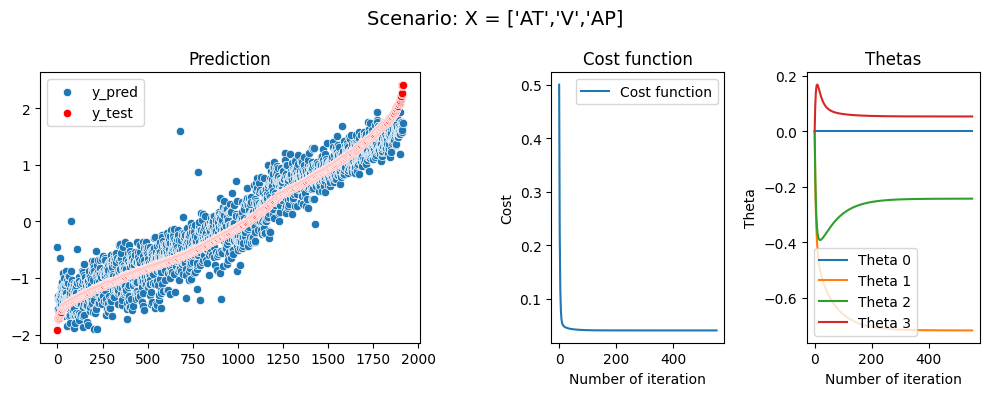

θ0        θ1        θ2        θ3        R2  \
Manual          9.031376e-16 -0.716818 -0.242552  0.053326  0.915482   
SkLearn         9.046426e-16 -0.716883 -0.242492  0.053317  0.915482   
Difference [%]  1.663702e-01 -0.009119 -0.024837  0.017741  0.000051   

                     MAE       MSE      RMSE  
Manual          0.229189  0.084518  0.290719  
SkLearn         0.229189  0.084518  0.290720  
Difference [%]  0.000114  0.000550  0.023462

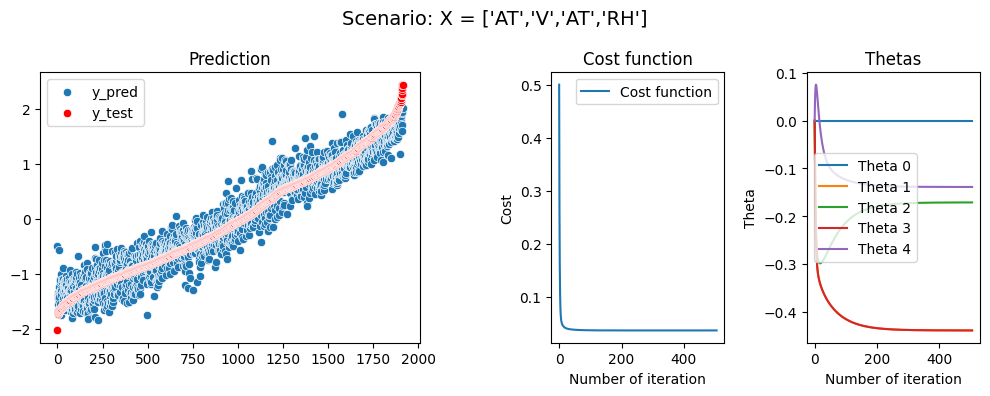

θ0            θ1        θ2            θ3        θ4  \
Manual          6.451993e-16 -4.394341e-01 -0.171350 -4.394341e-01 -0.138954   
SkLearn         6.399519e-16  4.352452e+12 -0.171387 -4.352452e+12 -0.139076   
Difference [%]  8.199642e-01  1.000000e+02 -0.021377 -1.000000e+02 -0.087368   

                      R2       MAE       MSE      RMSE  
Manual          0.929512  0.213380  0.070488  0.265497  
SkLearn         0.929488  0.213302  0.070512  0.265542  
Difference [%]  0.002580  0.036621  0.034006  0.184408

In [8]:
test1=MLR_Gradient("X = ['AT']",df2,0.8,["AT"],"PE",0.1,1000)
test2=MLR_Gradient("X = ['AT','V']",df2,0.8,["AT","V"],"PE",0.1,1000,True)
test3=MLR_Gradient("X = ['AT','V','AP]",df2,0.8,["AT","V","AP"],"PE",0.1,1000,True)
test4=MLR_Gradient("X = ['AT','V','AT','RH']",df2,0.8,["AT","V","AT","RH"],"PE",0.1,1000,True)

Graph comparing the different cost function results from the Scenario 1

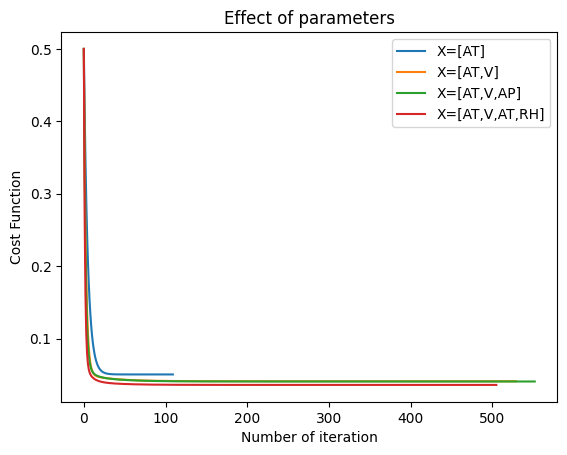

In [9]:
plot_graph(["X=[AT]","X=[AT,V]","X=[AT,V,AP]","X=[AT,V,AT,RH]"],"Effect of parameters",test1.hist_cost,test2.hist_cost,test3.hist_cost,test4.hist_cost)

Scenario 2 : Test of the Multi-Linear Regression with different learning rate parameters and analyse their effect on the model

Test5 : Learning rate : 0.1

Test6 : Learning rate : 0.01

Test7 : Learning rate : 0.001

Test8 : Learning rate : 0.0001

In this part we are setting the display parameter on False, because we will only compare the final result of the cost function between the different model.

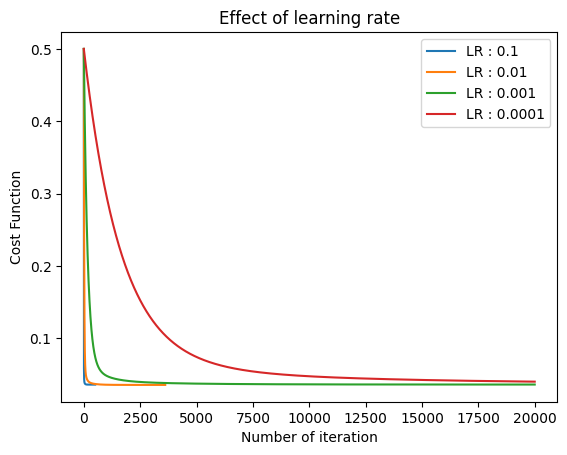

In [10]:
test5=MLR_Gradient("LR : 0.1",df2,0.8,["AT","V","AT","RH"],"PE",0.1,9000,False)
test6=MLR_Gradient("LR : 0.01",df2,0.8,["AT","V","AT","RH"],"PE",0.01,9000,False)
test7=MLR_Gradient("LR : 0.001",df2,0.8,["AT","V","AT","RH"],"PE",0.001,20000,False)
test8=MLR_Gradient("LR : 0.0001",df2,0.8,["AT","V","AT","RH"],"PE",0.0001,20000,False)
plot_graph(["LR : 0.1","LR : 0.01","LR : 0.001","LR : 0.0001"],"Effect of learning rate",test5.hist_cost,test6.hist_cost,test7.hist_cost,test8.hist_cost)

Comparing the number of iteration before convergence for each model

In [11]:
df_conv=pd.DataFrame(index=["Iteration before convergence"])
df_conv["LR : 0.1"]=test5.convergence
df_conv["LR : 0.01"]=test6.convergence
df_conv["LR : 0.001"]=test7.convergence
df_conv["LR : 0.0001"]=test8.convergence
display(df_conv)

LR : 0.1  LR : 0.01  LR : 0.001  LR : 0.0001
Iteration before convergence       506       3612       20000        20000

Scenario 3 : Test of the Multi-Linear Regression with different train/test ratio and analyse their effect on the model

Test9 : train/test ratio 0.6

Test10 : train/test ratio 0.7

Test11 : train/test ratio 0.8

Test12 : train/test ratio 0.9

In this part we are setting the display parameter on False, because we will only compare the final result and R2 metric to analyse the accuracy of our models.
For each model we are keeping all the different parameter, learning rate, iteration constant, only the train/test ratio vary

In [12]:
test9=MLR_Gradient("ratio : 0.4",df2,0.4,["AT","V","AT","RH"],"PE",0.01,9000,False)
test10=MLR_Gradient("ratio : 0.6",df2,0.6,["AT","V","AT","RH"],"PE",0.01,9000,False)
test11=MLR_Gradient("ratio : 0.8",df2,0.8,["AT","V","AT","RH"],"PE",0.01,9000,False)
test12=MLR_Gradient("ratio : 0.95",df2,0.95,["AT","V","AT","RH"],"PE",0.01,9000,False)
df_R2=pd.DataFrame(index=["R2 value"])
df_R2["ratio : 0.4"]=test9.r2
df_R2["ratio : 0.6"]=test10.r2
df_R2["ratio : 0.8"]=test11.r2
df_R2["ratio : 0.95"]=test12.r2
display(df_R2)

ratio : 0.4  ratio : 0.6  ratio : 0.8  ratio : 0.95
R2 value     0.926276     0.926709     0.927042      0.934579

Scenario 4 : Test of the Multi-Linear Regression with different iteration number and analyse their effect on the model

Test13 : Iteration 10

Test14 : Iteration 50

Test15 : Iteration 100

Test16 : Iteration 1000

In this part we are setting the display parameter on False, because we will only compare the final result and R2 metric to analyse the accuracy of our models.
For each model we are just varying the number of iteration in our models

In [13]:
test13=MLR_Gradient("Nbr Iter : 10",df2,0.8,["AT","V","AT","RH"],"PE",0.01,10,False)
test14=MLR_Gradient("Nbr Iter : 10",df2,0.8,["AT","V","AT","RH"],"PE",0.01,50,False)
test15=MLR_Gradient("Nbr Iter : 10",df2,0.8,["AT","V","AT","RH"],"PE",0.01,100,False)
test16=MLR_Gradient("Nbr Iter : 10",df2,0.8,["AT","V","AT","RH"],"PE",0.01,1000,False)
df_R2=pd.DataFrame(index=["R2 value"])
df_R2["Nbr Iter : 10"]=test13.r2
df_R2["Nbr Iter : 50"]=test14.r2
df_R2["Nbr Iter : 100"]=test15.r2
df_R2["Nbr Iter : 1000"]=test16.r2
display(df_R2)

Nbr Iter : 10  Nbr Iter : 50  Nbr Iter : 100  Nbr Iter : 1000
R2 value       0.410993       0.849571        0.899504         0.930845

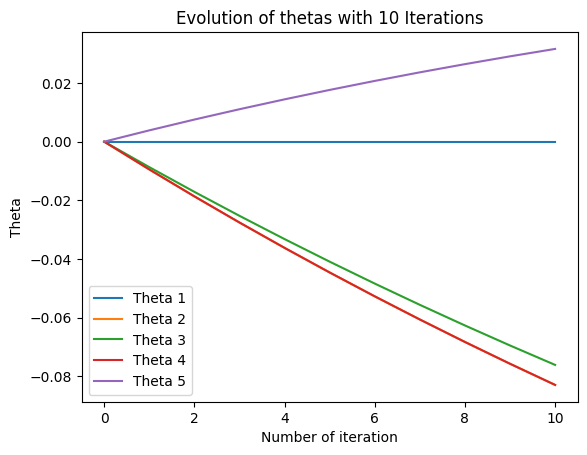

In [14]:
plt.plot(test13.hist_thetas, label=["Theta 1","Theta 2","Theta 3","Theta 4","Theta 5"])
plt.title("Evolution of thetas with 10 Iterations")
plt.xlabel("Number of iteration")
plt.ylabel("Theta")
plt.legend()

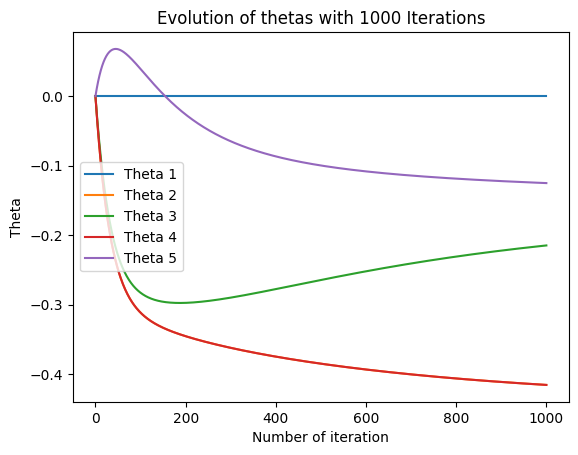

In [15]:
plt.plot(test16.hist_thetas, label=["Theta 1","Theta 2","Theta 3","Theta 4","Theta 5"])
plt.title("Evolution of thetas with 1000 Iterations")
plt.xlabel("Number of iteration")
plt.ylabel("Theta")
plt.legend()

Part II : DF1 : dataLoans

Interest.Rate  FICO.Score  Loan.Length  Monthly.Income  Loan.Amount  \
0            6.0       15.31        670.0            36.0      4891.67   
1           11.0       19.72        670.0            36.0      3575.00   
2           12.0       14.27        665.0            36.0      4250.00   
3           13.0       21.67        670.0            60.0     14166.67   
4           21.0       21.98        665.0            36.0      6666.67   

   Unnamed: 5  
0      6000.0  
1      2000.0  
2     10625.0  
3     28000.0  
4     22000.0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2499 entries, 0 to 2499
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Interest.Rate   2499 non-null   float64
 1   FICO.Score      2499 non-null   float64
 2   Loan.Length     2499 non-null   float64
 3   Monthly.Income  2499 non-null   float64
 4   Loan.Amount     2499 non-null   float64
 5   Unnamed: 5      2499 non-null   float64
dtypes: float64(6)
memory usage: 136.7 KB


None

Interest.Rate   FICO.Score  Loan.Length  Monthly.Income    Loan.Amount  \
count    2499.000000  2499.000000  2499.000000     2499.000000    2499.000000   
mean     1250.853541    13.069252   705.850340       41.262905    5688.931321   
std       721.760103     4.177544    34.989522        9.932322    3963.118185   
min         1.000000     5.420000   640.000000       36.000000     588.500000   
25%       626.500000    10.160000   680.000000       36.000000    3500.000000   
50%      1251.000000    13.110000   700.000000       36.000000    5000.000000   
75%      1875.500000    15.800000   725.000000       36.000000    6800.000000   
max      2500.000000    24.890000   830.000000       60.000000  102750.000000   

         Unnamed: 5  
count   2499.000000  
mean   12409.463786  
std     7801.698448  
min     1000.000000  
25%     6000.000000  
50%    10000.000000  
75%    17000.000000  
max    35000.000000

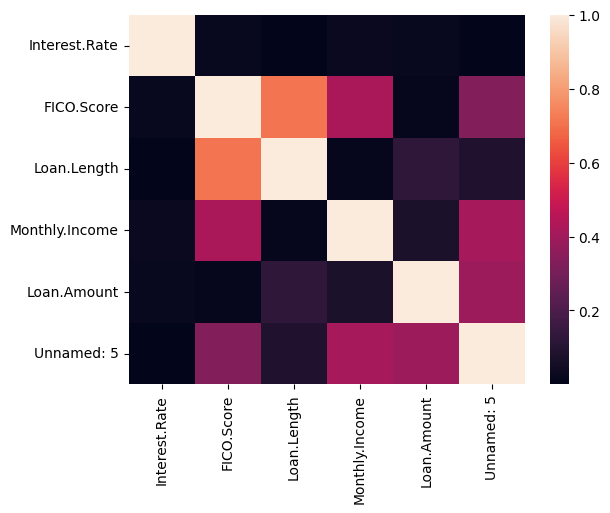

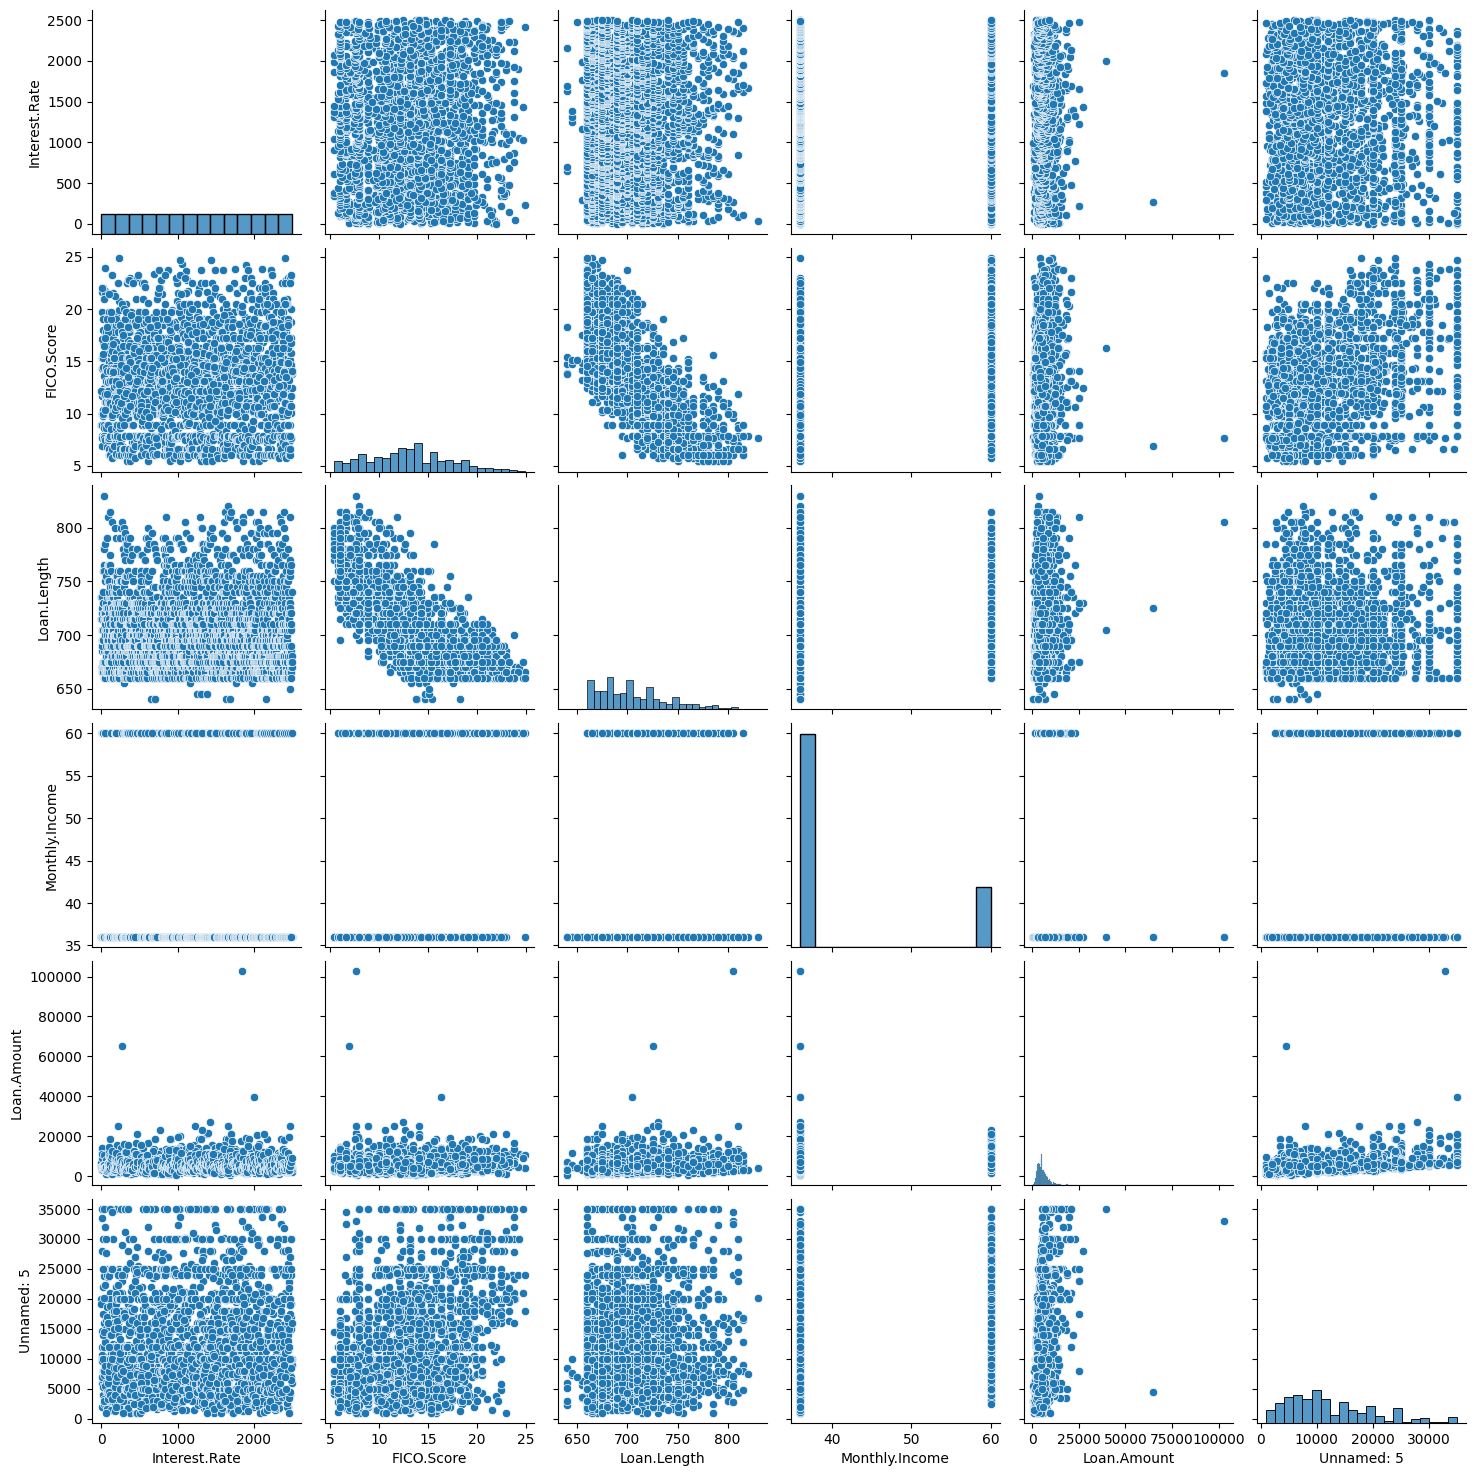

In [16]:
data_analyse(df1)

Scenario 5 :  We are testing our model with one time the value of dataLoan without cleaning the outliers and extreme value inside Loann.Amount and one time with dropping theses extreme values

-test17 : Train without cleaning the data

-test18 : Train with cleaning the data

In [17]:
df1.columns
df3=df1.copy()
df3=df3.drop(df3[df3["Loan.Amount"]>35000].index)

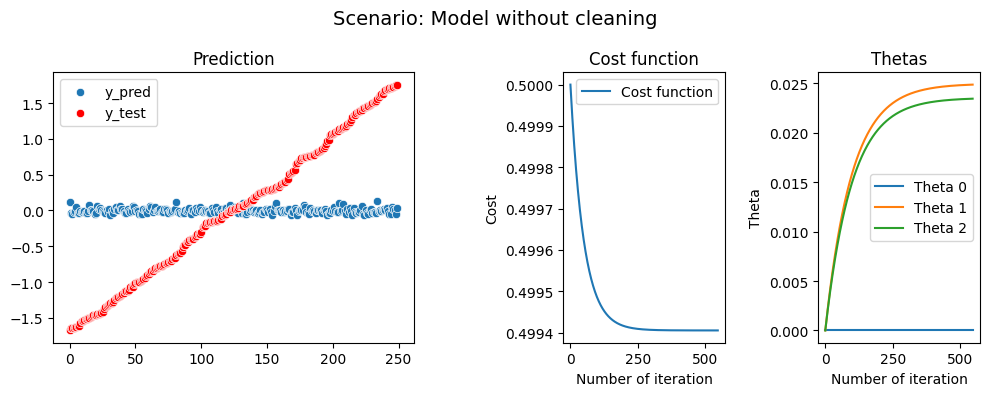

θ0        θ1        θ2        R2       MAE  \
Manual          4.072578e-17  0.024873  0.023450 -0.002261  0.851296   
SkLearn         4.509192e-17  0.024970  0.023541 -0.002274  0.851304   
Difference [%]  9.682748e+00  0.389008  0.386343 -0.596755  0.000981   

                     MSE      RMSE  
Manual          1.002261  1.001130  
SkLearn         1.002274  1.001136  
Difference [%]  0.001354  0.036797

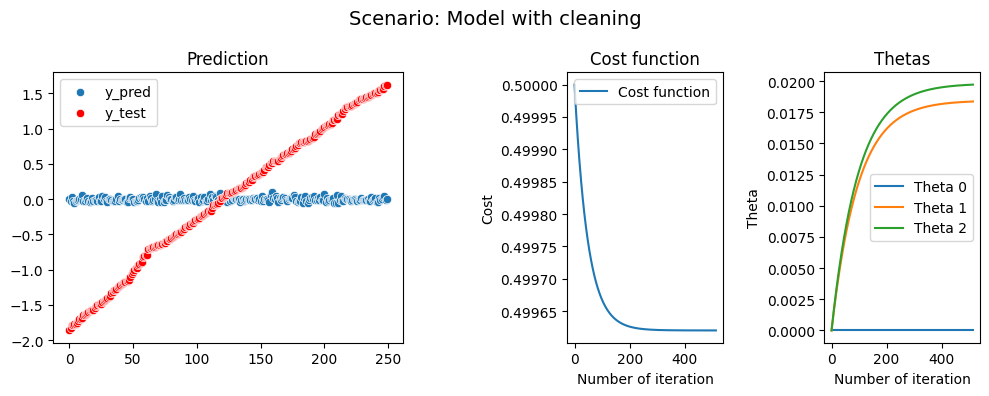

θ0        θ1        θ2        R2       MAE  \
Manual         -8.269234e-17  0.018361  0.019714  0.001486  0.858515   
SkLearn        -7.966494e-17  0.018447  0.019809  0.001489  0.858516   
Difference [%] -3.800163e+00  0.464314  0.479815  0.228178  0.000139   

                     MSE      RMSE  
Manual          0.998514  0.999257  
SkLearn         0.998511  0.999255  
Difference [%]  0.000340  0.018448

In [18]:
test17=MLR_Gradient("Model without cleaning",df1,0.9,["FICO.Score","Loan.Amount"],"Interest.Rate",0.01,2000,True)
test18=MLR_Gradient("Model with cleaning",df3,0.9,["FICO.Score","Loan.Amount"],"Interest.Rate",0.01,2000,True)

Scenario 6: We are testing to test our model with several new parameter to try to improve the accuracy of our model
New parameter:

    -LA*LA : Loan.amount square
                
    -FS*FS : Fico.Score square
                
    -LA*FS : Loan.Amount * FICO.Score

test19 : FS & LA (normal)

test20 : LA*LA & LA

test21 : FS*FS & FS

test22 : LA*FS & FS & LA


In [19]:
df1["LA*LA"]=df1["Loan.Amount"]*df1["Loan.Amount"]
df1["FS*FS"]=df1["FICO.Score"]*df1["FICO.Score"]
df1["LA*FS"]=df1["Loan.Amount"]*df1["FICO.Score"]

In [20]:
test19=MLR_Gradient("LA-FS",df1,0.8,["FICO.Score","Loan.Amount"],"Interest.Rate",0.01,2500,False)
test20=MLR_Gradient("LA*LA-LA",df1,0.8,["LA*LA","Loan.Amount"],"Interest.Rate",0.01,2500,False)
test21=MLR_Gradient("FS*FS-FS",df1,0.8,["FS*FS","FICO.Score"],"Interest.Rate",0.01,2500,False)
test22=MLR_Gradient("LA*FS-LA-FS",df1,0.8,["Loan.Amount","LA*FS","LA*LA"],"Interest.Rate",0.01,2500,False)
tests=[test19,test20,test21,test22]
df=pd.DataFrame(index=["R2 value"])
for test in tests:
    df[test.scenario]=test.r2
display(df)

LA-FS  LA*LA-LA  FS*FS-FS  LA*FS-LA-FS
R2 value -0.000873 -0.001859  0.000515      0.00484